# 随机梯度下降法

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time

# Tensorflow 已经把 mnist 数据集集成在 examples 里面了
# 在这里 import 数据输入的部分
import tensorflow.examples.tutorials.mnist.input_data as input_data
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(2017)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

train_set = mnist.train
test_set = mnist.test

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


### 构建模型

In [3]:
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None, weights_collection='weights', biases_collection='biases'):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        
        tf.add_to_collection(weights_collection, w)
        
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        
        tf.add_to_collection(biases_collection, b)
        
        net = tf.matmul(layer_input, w) + b
        
        return net
def DNN(x, output_depths, scope='DNN', reuse=None, weights_collection='weights', biases_collection='biases'):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse, weights_collection=weights_collection, biases_collection=biases_collection)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse, weights_collection=weights_collection, biases_collection=biases_collection)
    
    return net

# 定义占位符
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

dnn = DNN(input_ph, [200], weights_collection='params', biases_collection='params')

### 定义损失函数

In [4]:
# 构建`loss`和`acc`
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

在这里, 我们利用到`tensorflow`中的函数**`tf.add_to_collection`**,**`tf.get_collection`**

- `tf.add_to_collection(name, var)`会将`var`加入到名为`name`的`collection`的收集列表里面
- `tf.get_collection(name)`则会将名为`name`的收集列表中所有的变量取出

那么我们在定义变量的过程中就可以把他们加到名为`params`的列表中, 然后通过`get_collection`一次性取出

In [5]:
params = tf.get_collection('params')

通过`tf.gradients`计算梯度

In [6]:
gradients_for_params = tf.gradients(loss, params)

### 定义`SGD`下降算法
随机梯度下降法非常简单，公式就是
$$
\theta_{i+1} = \theta_i - \eta \nabla L(\theta)
$$
非常简单，我们可以从 0 开始自己实现

In [7]:
def sgd_update(params, gradients, lr, name='update_op'):
    update_ops = []
    for param, gradient in zip(params, gradients):
        # 对每个参数,减去学习率乘上梯度
        update_ops.append(param.assign_sub(lr * gradient))
        
    # 用`tf.group`将所有的更新`op`合并成一个`op`
    update_op = tf.group(*update_ops, name=name)
    return update_op

In [8]:
# 设置学习率为0.01
update_op = sgd_update(params, gradients_for_params, 0.01)

In [9]:
sess = tf.InteractiveSession()

### 训练
- 训练5个epoch
- 设置`batch_size=1`,也就是每过一个样本便更新一次参数

In [10]:
# 我们训练5个epoch, 设置`batch_size=1`

batch_size = 1

sess.run(tf.global_variables_initializer())

train_losses = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    # 每30步记录一次误差
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
        
    sess.run(update_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.097288
Epoch 2 Train loss: 0.056874
Epoch 3 Train loss: 0.042088
Epoch 4 Train loss: 0.041094
Epoch 5 Train loss: 0.021083
Train Done! Cost Time: 336.41s


In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

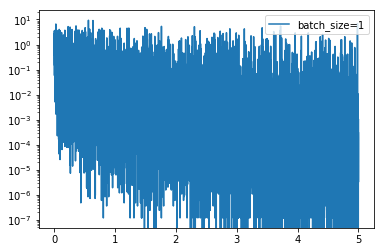

In [12]:
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='batch_size=1')
plt.legend(loc='best')

可以看到, 训练误差震荡非常厉害, 非常不稳定, 而且训练时间非常长, 接下来我们试着将`batch_size`改为64

### 增大`batch_size`

In [13]:
# 我们设置`batch_size=64`

batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
        
    sess.run(update_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.504010
Epoch 2 Train loss: 0.388880
Epoch 3 Train loss: 0.342270
Epoch 4 Train loss: 0.313399
Epoch 5 Train loss: 0.292673
Train Done! Cost Time: 11.13s


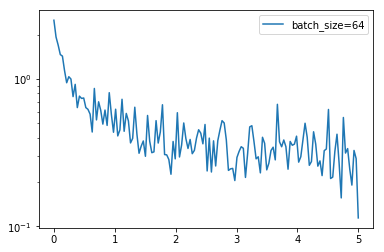

In [14]:
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='batch_size=64')
plt.legend(loc='best')

通过上面的结果可以看到 loss 没有 batch 等于 1 震荡那么距离，同时也可以降到一定的程度了，时间上也比之前快了非常多，因为按照 batch 的数据量计算上更快，同时梯度对比于 batch size = 1 的情况也跟接近真实的梯度，所以 batch size 的值越大，梯度也就越稳定，而 batch size 越小，梯度具有越高的随机性，这里 batch size 为 64，可以看到 loss 仍然存在震荡，但这并没有关系，如果 batch size 太大，对于内存的需求就更高，同时也不利于网络跳出局部极小点，所以现在普遍使用基于 batch 的随机梯度下降法，而 batch 的多少基于实际情况进行考虑

### 增大学习率

In [15]:
update_op2 = sgd_update(params, gradients_for_params, 2.0)

In [16]:
# 学习率是2.0

batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
    
    # 使用1.0的学习率
    sess.run(update_op2, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 1.773169
Epoch 2 Train loss: 1.722485
Epoch 3 Train loss: 1.733557
Epoch 4 Train loss: 1.739943
Epoch 5 Train loss: 1.744911
Train Done! Cost Time: 10.93s


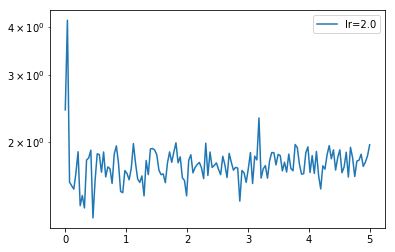

In [17]:
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='lr=2.0')
plt.legend(loc='best')

可以看到, 训练误差一直在较高的位置震荡, 难以收敛, 因此我们一般不用大学习率

### `SGD` in `Tensorflow`

In [18]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [19]:
# 我们设置`batch_size=64`

batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
    
    # 使用`tensorflow`自带的`SGD`
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.504185
Epoch 2 Train loss: 0.391761
Epoch 3 Train loss: 0.345504
Epoch 4 Train loss: 0.316845
Epoch 5 Train loss: 0.294635
Train Done! Cost Time: 10.83s


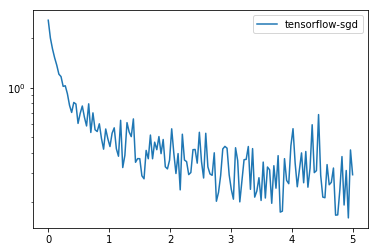

In [20]:
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='tensorflow-sgd')
plt.legend(loc='best')